<a href="https://colab.research.google.com/github/finfrierson/code_challenges_for_fin/blob/master/Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:

!pip install "preliz[full,notebook]"

In [87]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import preliz as pz

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
#Setup
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
aa_coords = {"aa": aa_encode.categories}
aa_coords


{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [ ]:
#Copy of Original Model
with pm.Model(coords=aa_coords) as cs_nh_model:
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="aa")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=cs_data.diff_TminusE)

    #cs for chemshift, nh for nonheirarchical
    idata_cs_nh = pm.sample()

Output()

Output()

In [ ]:
#New Model
with pm.Model(coords=aa_coords) as st_t_model:
    μ_mu = pm.StudentT('μ_mu', nu=1, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=1, sigma = 10)
    μ_nu = pm.HalfStudentT('μ_nu', nu=1, sigma = 1)


    μ = pm.StudentT('μ', nu=μ_nu, mu=μ_mu, sigma=μ_sd,
                  dims="aa")
    σ = pm.HalfStudentT('σ', nu=1, sigma=10,
                      dims="aa")
    ν = pm.HalfStudentT('ν',nu=1, sigma=1)

    y = pm.StudentT('y',
                  nu= ν,
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=cs_data.diff_TminusE)

    idata_st_t = pm.sample()

Output()

Output()

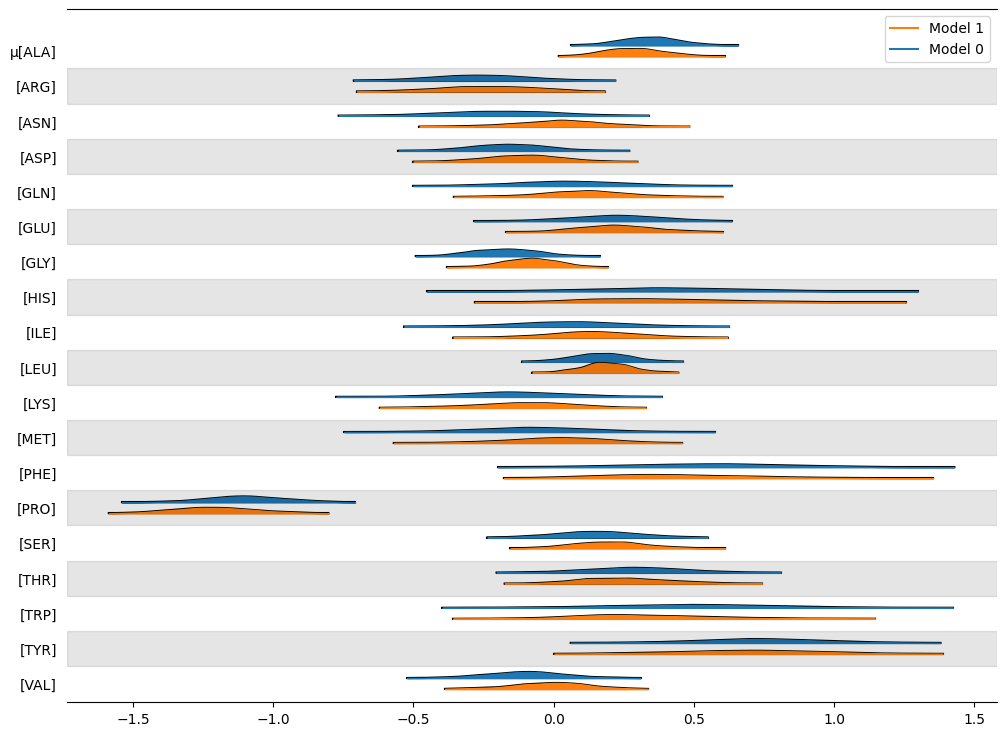

In [ ]:
#Original Plotted
axes = az.plot_forest([idata_cs_nh, idata_st_t], kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

The student T model has more propensity to outliers because of it having Kurtosis. The normal model does not have this. Additionally, the Student T models tend to center closer to 0.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
#Gathering stuff
pm.sample_posterior_predictive(idata_cs_nh, model=cs_nh_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [ ]:
#Gathering Stuff
pm.sample_posterior_predictive(idata_st_t, model=st_t_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

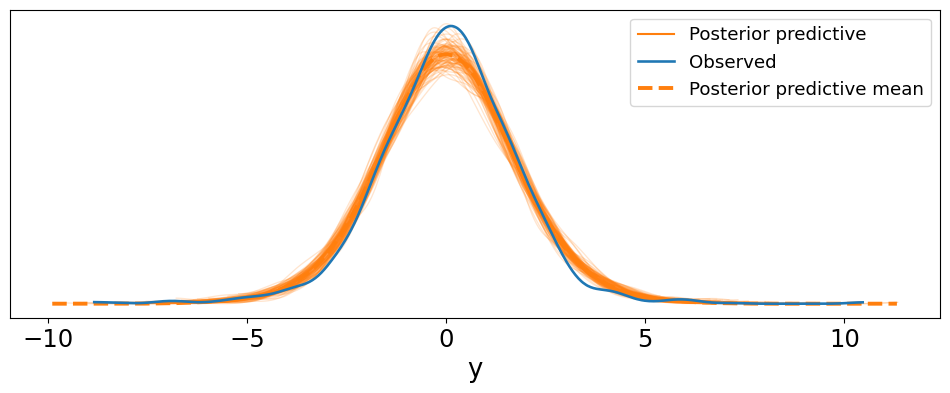

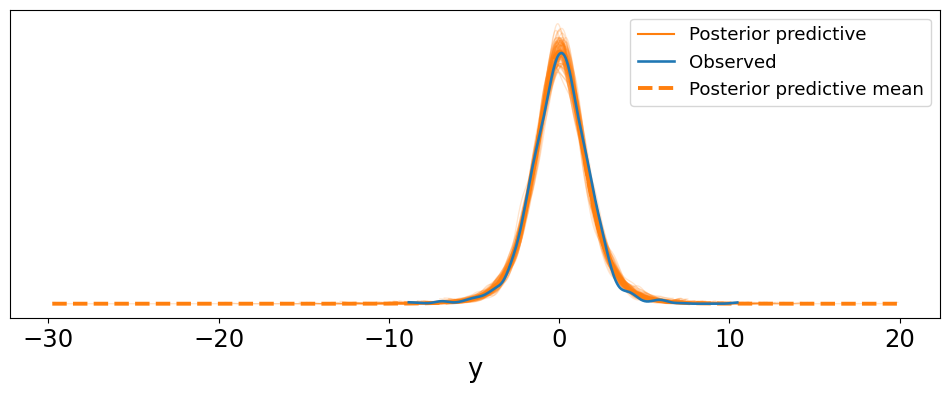

In [ ]:
#Plotting the posterior predictives (Top is old model, bottom is new)
az.plot_ppc(idata_cs_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
az.plot_ppc(idata_st_t, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The Student T model definitely fits better. The posterior predictive is right along the observed,whereas the Normal model is not along the observed at the peak and bottom sides.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
#Grabbing Data
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

#Getting positions and putting them in a dictionary
pos_idx = sccr_data.position.cat.codes.values

pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [ ]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
#New Model
with pm.Model(coords = sccr_coords) as sccr_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = .1, nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    idata_sccr = pm.sample(target_accept = 0.95)


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

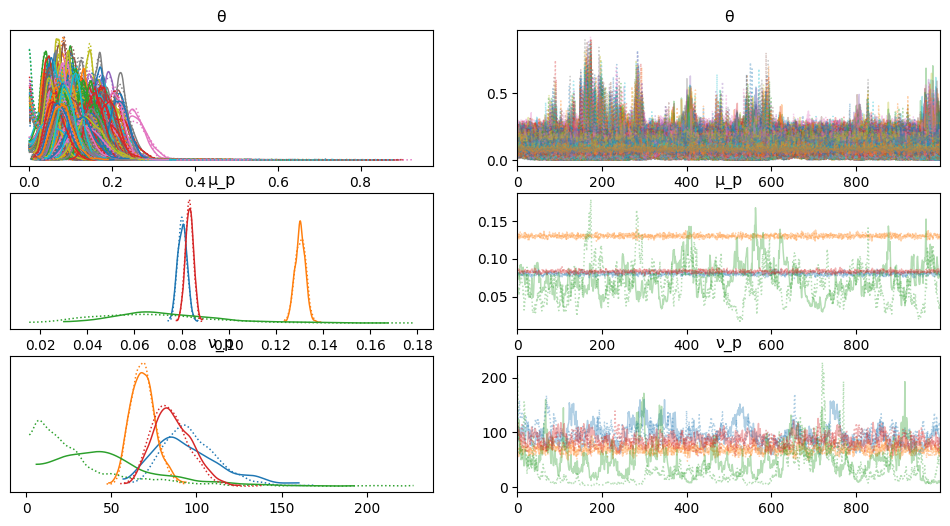

In [ ]:
az.plot_trace(idata_sccr)

In [ ]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.006 1.001 1.001 ... 0.9997 1.001 1.001
    μ_p      (pos) float64 32B 1.0 1.003 1.074 1.001
    ν_p      (pos) float64 32B 1.032 1.003 1.616 1.012

Compared to the Hierarchial model (Using the one in notes as a reference, I really dont want to spend ten minutes running it again here), the plots on the heirarchial model have more extreme outliers, but slightly more concentrated graphs. Additionaly the Rhat values for this model appears to be better overall, but both models appear to be quite similar.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: title={'center': '99.8% HDI'}>], dtype=object)

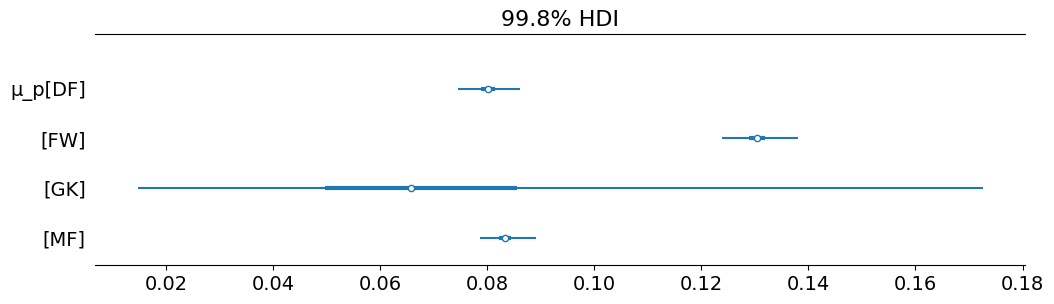

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'forestplot', hdi_prob=0.998)

Again, the models arent too different. The only position I really notice much

of a difference in is the one for goalkeepers, as it is stretched out farther than before, yet has the highest thickness earlier on. This is likely due to goalkeepers now not being regulated at all by the values of other positions with hyper priors.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [88]:
#Re-Grabbing Data but ignoring goal keepers
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
sccr_data = sccr_data[sccr_data['position']!='GK']
sccr_data = sccr_data.assign(position=sccr_data['position'].cat.remove_unused_categories())
#I know you were mentioning using query but I could not figure out how to do it with that. Removing the unused categories does work with my previous method I used to remove the goalkeepers
pos_idx = sccr_data.position.cat.codes.values

pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [ ]:
pos_codes

Index(['DF', 'FW', 'MF'], dtype='object')

In [ ]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [89]:
#Hierarchical model with
with pm.Model(coords = sccr_coords) as sccr_model:

    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)

    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values,
                    p = θ,
                    observed = sccr_data.goals.values)


    idata_sccr2 = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

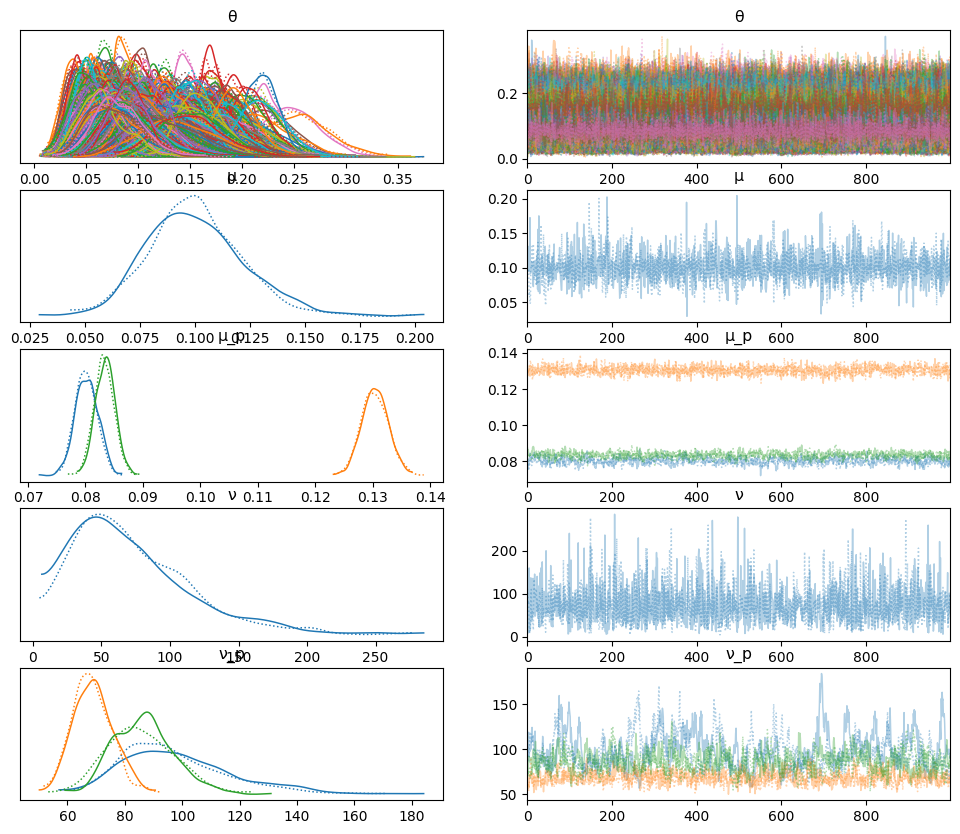

In [90]:
az.plot_trace(idata_sccr2)

In [91]:
az.rhat(idata_sccr2)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.0 1.004 0.9998 1.002 ... 1.002 0.9994 1.0
    μ        float64 8B 1.002
    μ_p      (pos) float64 24B 1.002 1.0 1.005
    ν        float64 8B 1.001
    ν_p      (pos) float64 24B 1.009 1.001 1.007

Compared to the model with GKs(Using the one rom the notes), the μ model of this one has no extreme outliers, and similar but not quite as noticeable with the other plots. THe Rhat values are also slightly better, though still not extremely important. The biggest change for this model is consistancy in most ways.
This model also took overall less time to process, but still a couple of minutes. From dropping Gks we lose a position. While they dont shoot often, they still are a position that can shoot, so our models scope is lowered. However the consistancy gained makes this model quite worthwhile.